# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [ ]:
#importing libraries
import numpy as np
np.bool = np.bool_ #monkey patch for version of numpy that conflicts with shap
import pandas as pd 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import pickle
import shap



c:\Users\tsuit\miniconda3\envs\dsi_participant_2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [ ]:
# area is the target, features is everything else

X = fires_dt.drop(columns = 'area')
Y = fires_dt['area']


In [ ]:
# creating train and test data sets

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


In [ ]:
# show all columns to help make list
fires_dt.columns

Index(['coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi',
       'temp', 'rh', 'wind', 'rain', 'area'],
      dtype='object')

### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [ ]:
# define numeric columns and categorical columns

num_cols1 = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
cat_cols1 = ['month','day']

# set StandarScaler() as standardizer for numeric columns
preproc_1_num_simple = Pipeline([
    ('standardizer', StandardScaler()),
])
# set OneHotEncoder for categorical columns
preproc_1_category = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist')),
])
# create column transformer
preproc_1 = ColumnTransformer([
    ('categorical', preproc_1_category, cat_cols1),
    ('numeric_simple', preproc_1_num_simple, num_cols1),
], remainder= 'passthrough')

preproc_1
                             

ColumnTransformer(remainder='passthrough',
                  transformers=[('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                 ['month', 'day']),
                                ('numeric_simple',
                                 Pipeline(steps=[('standardizer',
                                                  StandardScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [ ]:
# define numeric, numeric to transform, and categorical

num_cols_2 = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi']
num_cols_transform_2 = ['temp', 'rh', 'wind', 'rain']
cat_cols2 = ['month', 'day']

# standardizer
preproc_2_num_simple = Pipeline([
    ('standardizer', StandardScaler()),
])
# standardizer and Yeo-Johnson transformation
preproc_2_num_yj = Pipeline([
    ('standardizer', StandardScaler()),
    ('transform', PowerTransformer(method= 'yeo-johnson'))
])
# onehotencoder
preproc_2_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist')),
])
#column transformer
preproc_2 = ColumnTransformer([
    ('categorical', preproc_2_cat, cat_cols2),
    ('numeric_simple', preproc_2_num_simple, num_cols_2),
    ('nuemric_yj', preproc_2_num_yj, num_cols_transform_2),
], remainder= 'passthrough')

preproc_2

ColumnTransformer(remainder='passthrough',
                  transformers=[('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                 ['month', 'day']),
                                ('numeric_simple',
                                 Pipeline(steps=[('standardizer',
                                                  StandardScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi']),
                                ('nuemric_yj',
                                 Pipeline(steps=[('standardizer',
                                                  StandardScaler()),
                                                 ('transform',
                                                  PowerTransformer())]),
                                 ['temp', 'rh', 'wind', 'rain'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [ ]:
# Pipeline A = preproc1 + baseline 

#model: KNN Regression

# setting preprocessing and regressor
pipeline_a = Pipeline([
    ('preprocessing', preproc_1),
    ('regressor', KNeighborsRegressor())
])
# tuning n_neighbors: setting parameter grid
param_grid_a = {
    'regressor__n_neighbors': range(1,201,5)
}
# tuning n_neighbouts: using grid search to find best valule of n_neighbors
a_gridsearch = GridSearchCV(
    estimator= pipeline_a,
    param_grid=param_grid_a,
    cv=5,
    scoring='neg_mean_absolute_error'
)
#fitting model to training data
a_gridsearch.fit(X_train, Y_train)

#saving model with value of n_neighbors
best_model_a = a_gridsearch.best_estimator_

#cross validate
res_a_dict = cross_validate(
    estimator=best_model_a,
    X= X_train,
    y= Y_train,
    cv=5,
    scoring='neg_mean_absolute_error'
)
#display results in dataframe
res_a = pd.DataFrame(res_a_dict).assign(experiment=1)
res_a

,fit_time,score_time,test_score,experiment
0,0.003936,0.017204,-16.235834,1
1,0.007004,0.015161,-11.992725,1
2,0.006001,0.015000,-14.305477,1
3,0.004001,0.011997,-22.552411,1
4,0.004003,0.013997,-11.812326,1


In [ ]:
# Pipeline B = preproc2 + baseline

#model: KNN Regression

pipeline_b = Pipeline([
    ('preprocessing', preproc_2),
    ('regressor', KNeighborsRegressor())
])
# tuning n_neighbors: setting parameter grid
param_grid_b = {
    'regressor__n_neighbors': range(1,201,5)
}
# tuning n_neighbouts: using grid search to find best valule of n_neighbors
b_gridsearch = GridSearchCV(
    estimator=pipeline_b,
    param_grid= param_grid_b,
    cv= 5,
    scoring= 'neg_mean_absolute_error'
)
#fitting model to training data
b_gridsearch.fit(X_train, Y_train)

#saving model with value of n_neighbors
best_model_b = b_gridsearch.best_estimator_

#cross validate
res_b_dict = cross_validate(
    estimator= best_model_b,
    X= X_train,
    y= Y_train,
    cv= 5,
    scoring= 'neg_mean_absolute_error'
)
#display results in dataframe
res_b = pd.DataFrame(res_b_dict).assign(experiment= 2)
res_b


,fit_time,score_time,test_score,experiment
0,0.009003,0.021048,-15.547764,2
1,0.008003,0.019779,-11.918313,2
2,0.010001,0.019147,-14.828280,2
3,0.009997,0.022000,-22.222385,2
4,0.008642,0.023194,-11.324180,2


In [ ]:
# Pipeline C = preproc1 + advanced model

#model = BaggingRegressor (with DecisionTreeRegressor as default)
pipeline_c = Pipeline([
    ('preprocesing', preproc_1),
    ('regressor', BaggingRegressor(random_state=42, n_jobs=2))#set random state to 42 for repeatability and specied jobs as 2 for faster time
])

#cross_validate
res_c_dict = cross_validate(
    estimator=pipeline_c,
    X=X_train,
    y=Y_train,
    cv=5,
    scoring= 'neg_mean_absolute_error'
)
#display results in dataframe
res_c = pd.DataFrame(res_c_dict).assign(experiment = 3)
res_c

,fit_time,score_time,test_score,experiment
0,0.947530,0.015951,-20.739596,3
1,0.029162,0.016167,-23.758396,3
2,0.029358,0.016314,-18.886386,3
3,0.028708,0.015686,-27.490264,3
4,0.029878,0.015185,-10.631821,3


In [ ]:
# Pipeline D = preproc2 + advanced model

#model = BaggingRegressor (with DecisionTreeRegressor as default)
pipeline_d = Pipeline([
    ('preprocessing', preproc_2),
    ('regressor', BaggingRegressor(random_state=42, n_jobs=2)) #set random state to 42 for repeatability and specied jobs as 2 for faster time
])
#cross validate
res_d_dict = cross_validate(
    estimator=pipeline_d,
    X=X_train,
    y=Y_train,
    cv=5,
    scoring= 'neg_mean_absolute_error'
)
#display results in dataframe
res_d = pd.DataFrame(res_d_dict).assign(experiment = 4)
res_d

,fit_time,score_time,test_score,experiment
0,0.041364,0.030374,-20.613235,4
1,0.029458,0.031255,-25.399283,4
2,0.029003,0.016004,-19.541072,4
3,0.029351,0.030171,-27.336081,4
4,0.028462,0.015368,-10.672752,4


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [ ]:
#  displaying KNN params for pipes a and b

best_model_a.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('categorical',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                    ['month', 'day']),
                                   ('numeric_simple',
                                    Pipeline(steps=[('standardizer',
                                                     StandardScaler())]),
                                    ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                     'isi', 'temp', 'rh', 'wind', 'rain'])])),
  ('regressor', KNeighborsRegressor(n_neighbors=26))],
 'verbose': False,
 'preprocessing': ColumnTransformer(remainder='passthrough',
                   transformers=[('categorical',
                                  Pipeline(steps=[('onehot',
                             

In [ ]:
#setting hyperparameters to tune as p and weights
param_grid_hyper_a = {
    'regressor__p':[1,2],
    'regressor__weights': ['uniform', 'distance']
}
# GrisSearch across params
a_grid = GridSearchCV(
    estimator=best_model_a,
    param_grid=param_grid_hyper_a,
    scoring = 'neg_mean_absolute_error',
    cv = 5,
    refit= 'neg_mean_absolute_error'
)
#fit model
a_grid.fit(X_train, Y_train)
#display results in datafram
res_a = pd.DataFrame(a_grid.cv_results_)
res_a

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__p,param_regressor__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005604,0.001629,0.007730,0.001773,1,uniform,"{'regressor__p': 1, 'regressor__weights': 'uni...",-17.010352,-14.135019,-15.316367,-22.882758,-13.037519,-16.476403,3.463529,4
1,0.005644,0.001193,0.013151,0.000458,1,distance,"{'regressor__p': 1, 'regressor__weights': 'dis...",-16.864002,-14.243357,-15.579735,-22.361412,-12.184729,-16.246647,3.427203,3
2,0.004315,0.001465,0.009027,0.000851,2,uniform,"{'regressor__p': 2, 'regressor__weights': 'uni...",-16.235834,-11.992725,-14.305477,-22.552411,-11.812326,-15.379755,3.937828,2
3,0.005119,0.001191,0.011261,0.001173,2,distance,"{'regressor__p': 2, 'regressor__weights': 'dis...",-16.086784,-12.216691,-14.518998,-22.090217,-11.297357,-15.242009,3.816993,1


In [ ]:
#setting hyperparameters to tune as weights and metric

param_grid_hyper_b = {
    'regressor__weights':['uniform', 'distance'],
    'regressor__metric': ['minkowski', 'manhattan']
}
# GridSearch across params
b_grid = GridSearchCV(
    estimator=best_model_b,
    param_grid=param_grid_hyper_b,
    scoring = 'neg_mean_absolute_error',
    cv = 5,
    refit= 'neg_mean_absolute_error'
)
# fit model
b_grid.fit(X_train, Y_train)
#display results in dataframe
res_b = pd.DataFrame(b_grid.cv_results_)
res_b

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__metric,param_regressor__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.01144,0.002113,0.017711,0.002528,minkowski,uniform,"{'regressor__metric': 'minkowski', 'regressor_...",-15.547764,-11.918313,-14.828280,-22.222385,-11.324180,-15.168184,3.882252,2
1,0.01447,0.002949,0.021779,0.002347,minkowski,distance,"{'regressor__metric': 'minkowski', 'regressor_...",-15.552628,-12.110397,-14.740060,-21.796563,-10.860822,-15.012094,3.796001,1
2,0.00975,0.000757,0.009809,0.002441,manhattan,uniform,"{'regressor__metric': 'manhattan', 'regressor_...",-16.760773,-13.018822,-14.657062,-22.863154,-12.820566,-16.024075,3.700769,4
3,0.01342,0.003344,0.018838,0.001239,manhattan,distance,"{'regressor__metric': 'manhattan', 'regressor_...",-16.656971,-13.299042,-14.810283,-22.459198,-12.059189,-15.856937,3.641184,3


In [ ]:
#diplay params for BaggingRegressor

pipeline_c.get_params()

{'memory': None,
 'steps': [('preprocesing',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('categorical',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                    ['month', 'day']),
                                   ('numeric_simple',
                                    Pipeline(steps=[('standardizer',
                                                     StandardScaler())]),
                                    ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                     'isi', 'temp', 'rh', 'wind', 'rain'])])),
  ('regressor', BaggingRegressor(n_jobs=2, random_state=42))],
 'verbose': False,
 'preprocesing': ColumnTransformer(remainder='passthrough',
                   transformers=[('categorical',
                                  Pipeline(steps=[('onehot',
                       

In [ ]:
#setting hyperparameter to tune as range of n_estimators
param_grid_hyper_c = {
    'regressor__n_estimators': range(1,19,2)  
}

#gridsearch across params
c_grid = GridSearchCV(
    estimator=pipeline_c,
    param_grid=param_grid_hyper_c,
    scoring = 'neg_mean_absolute_error',
    cv = 5,
    refit= 'neg_mean_absolute_error'
)
# fit model
c_grid.fit(X_train, Y_train)

#display results in dataframe
res_c = pd.DataFrame(c_grid.cv_results_)
res_c

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007073,0.000704,0.002857,0.000367,1,{'regressor__n_estimators': 1},-34.519438,-29.378434,-47.747349,-25.910691,-11.395366,-29.790256,11.818756,9
1,0.192476,0.326526,0.015814,0.000289,3,{'regressor__n_estimators': 3},-24.201499,-20.671165,-27.160161,-30.441667,-12.412740,-22.977446,6.190960,8
2,0.022430,0.006230,0.016736,0.000935,5,{'regressor__n_estimators': 5},-22.633454,-22.873165,-21.309831,-30.620358,-11.729154,-21.833192,6.021656,7
3,0.029154,0.000737,0.015694,0.000669,7,{'regressor__n_estimators': 7},-21.715855,-23.827398,-20.227625,-28.961928,-11.084425,-21.163446,5.842611,6
4,0.029397,0.000347,0.015630,0.000547,9,{'regressor__n_estimators': 9},-21.745531,-22.752903,-19.599036,-28.600876,-10.192430,-20.578155,5.987960,5
5,0.030101,0.000846,0.015192,0.000321,11,{'regressor__n_estimators': 11},-20.305350,-22.646406,-18.350986,-27.735147,-10.686024,-19.944783,5.592555,2
6,0.029656,0.000768,0.015464,0.000222,13,{'regressor__n_estimators': 13},-20.183285,-22.065202,-17.422595,-26.785811,-11.155428,-19.522464,5.178323,1
7,0.033028,0.006131,0.016008,0.000402,15,{'regressor__n_estimators': 15},-20.273795,-24.515438,-17.153124,-27.113881,-10.888884,-19.989025,5.695401,3
8,0.029420,0.000460,0.015564,0.000277,17,{'regressor__n_estimators': 17},-20.683651,-24.413358,-16.997236,-26.598166,-11.386626,-20.015808,5.416391,4


In [ ]:
#setting hyperparameter to tune as max_samples
param_grid_hyper_d = {
    'regressor__max_samples': [0.25, 0.50, 0.75, 1.0]
}

#gridsearch across params
d_grid = GridSearchCV(
    estimator=pipeline_d,
    param_grid=param_grid_hyper_d,
    scoring = 'neg_mean_absolute_error',
    cv = 5,
    refit= 'neg_mean_absolute_error'
)
#fit model
d_grid.fit(X_train, Y_train)

#display results in dataframe
res_d = pd.DataFrame(d_grid.cv_results_)
res_d

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_samples,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.027976,0.002320,0.022518,0.008030,0.25,{'regressor__max_samples': 0.25},-20.442843,-27.985783,-21.067928,-25.585598,-19.731774,-22.962785,3.240052,4
1,0.029188,0.001045,0.018695,0.005509,0.5,{'regressor__max_samples': 0.5},-23.471811,-23.999249,-18.674265,-25.716138,-13.775063,-21.127305,4.356031,2
2,0.028791,0.000807,0.021940,0.007717,0.75,{'regressor__max_samples': 0.75},-19.254892,-29.994094,-20.969876,-30.056608,-13.165959,-22.688286,6.528136,3
3,0.033698,0.005594,0.015618,0.000377,1.0,{'regressor__max_samples': 1.0},-20.613235,-25.399283,-19.541072,-27.336081,-10.672752,-20.712485,5.796834,1


# Evaluate

+ Which model has the best performance?

# Export

+ Save the best performing model to a pickle file.

In [ ]:
#best overall model by chosen metric (mean absolute error) is model b

#defining best model
best_overall_model = b_grid.best_estimator_
#saving best performing model to pickle dile
filename = 'assignment_2_best_model.sav'
pickle.dump(b_grid.best_estimator_, open(filename, 'wb'))

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [ ]:
#monkey patch for numpy issue in shap
np.int = int

#fit best model
best_overall_model.fit(X_train,Y_train)

#define transformations
data_transform = best_overall_model.named_steps['preprocessing'].transform(X_test)

#set background value (necesaru for KernelExplainer)
background = data_transform[:100]

#set explainer as KeneralExplainer (best for KNN Regression)
explainer = shap.KernelExplainer(
    best_overall_model.named_steps['regressor'].predict,
    background
)
#create array of shap values
shap_values_array = explainer.shap_values(data_transform)

#wrap shap values in explanation to ensure compatabilitu with shap plots
shap_values = shap.Explanation(
    values=shap_values_array,
    base_values= explainer.expected_value,
    data = data_transform,
    feature_names = best_overall_model.named_steps['preprocessing'].get_feature_names_out()
)

100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


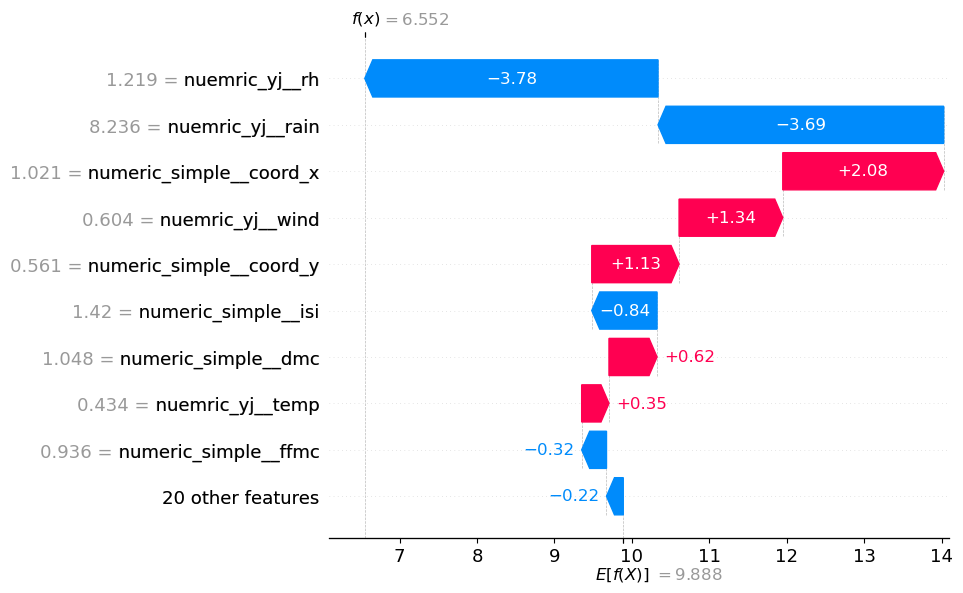

In [ ]:
#shap waterfall plot (local)
shap.plots.waterfall(shap_values[1])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


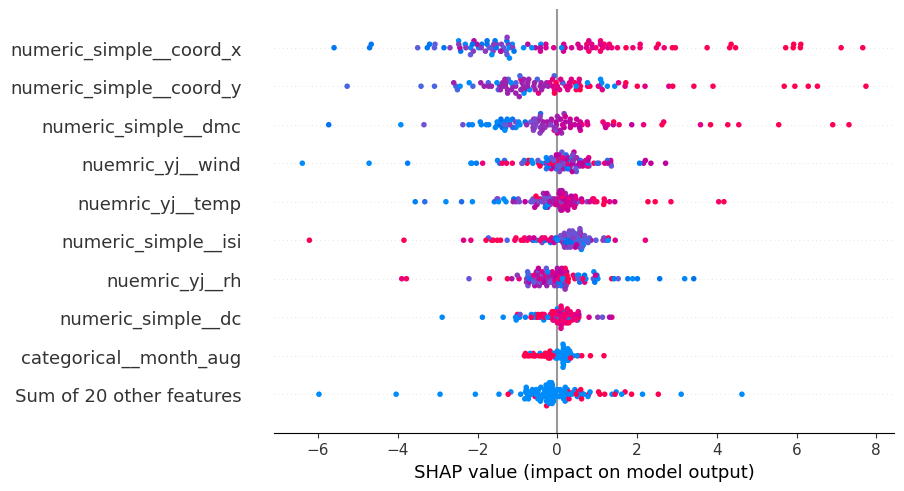

In [ ]:
#set color_bar as False as it was causing the labels to not show up
# shap beeswarm for global
shap.plots.beeswarm(shap_values, color_bar= False)


In the selected observation shown in the waterfall plot, the most important features are relative humidity and rain, both which push the model towards a lower area. This makes sense as having a higher relative humidity and rainfall which very much hinder the spread of fires. 

Across the entire training set, the most important features are coord x and y, in which higher values push the model towards a higher area, along with the dmc value, which is a numeric rating of average moisture content of part of the ground (source). Higher values indicate decreased moisture content (source2). The higher valeues of coords would suggest that there is a specific corner of the park in which fires get bigger. 

The least important features appear to be the categorical features (month and day), as the only one that makes it into the top 10 is the month of august, and not other values of month or day are present in the top. 

If I were to remove features, if would be month and day, as they appear to have the least effect on the model. We could compare the error values for models that include them and don't include them. Based on the beeswarm model, though, they appear to have minimal eeffect on the model as the only month that shows up is aug, which has shap values no larger than +/- 2, compared to valuess closer to +/- 8 for coords and dmc.


source: https://www2.gov.bc.ca/gov/content/safety/wildfire-status/prepare/weather-fire-danger/fire-weather/fire-weather-index-system
source2: https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.